# 1. EXPLORATORY DATA ANALYSIS (EDA)

The goal of this section is to understand the data before modelling.

1.  Analyze the 15 power plants: production variance and missing values.
2.  Check correlations between weather variables to identify redundancy.

In [ ]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import shap


In [ ]:
# EXPORTING DATA
train_url = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Train.csv"
test_url  = "https://raw.githubusercontent.com/LeHoangViet03/Fintech-CYTech/main/Energy_Production_Test.csv"

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

print(train.shape, test.shape)

# Define main columns
plant_col = "Plant_ID"
time_col = "UTC Time"
target_col = "Energy_Production"

# Parse timestamps and sort by plant and time
train[time_col] = pd.to_datetime(train[time_col])
test[time_col]  = pd.to_datetime(test[time_col])

train = train.sort_values([plant_col, time_col]).reset_index(drop=True)
test  = test.sort_values([plant_col, time_col]).reset_index(drop=True)

train.head()


(176505, 17) (59376, 17)


,UTC Time,Plant_ID,Energy_Production,Benchmark,Day-Night,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
0,2020-01-04 00:00:00+00:00,0,0.0,0.0,N,4.0,1.23,17.21,1.0,0.0,0.0,2.5,277.0,0,2.0,84.0,5.04
1,2020-01-04 01:00:00+00:00,0,0.0,0.0,N,4.0,0.28,17.39,1.0,0.0,-0.3,1.8,290.0,0,2.0,86.0,5.40
2,2020-01-04 02:00:00+00:00,0,0.0,0.0,N,4.0,-0.89,18.57,0.0,0.0,-0.7,0.9,297.0,0,2.0,89.0,5.76
3,2020-01-04 03:00:00+00:00,0,0.0,0.0,N,4.0,-1.96,19.75,0.0,0.0,-1.1,0.1,300.0,0,2.0,92.0,6.12
4,2020-01-04 04:00:00+00:00,0,0.0,0.0,N,3.0,-2.30,19.93,0.0,0.0,-1.4,-0.2,299.0,0,2.0,92.0,6.12


## Data Loading (initial overview)

We load the training and test datasets provided for the project (as URLs).  
The datasets contain hourly observations of weather conditions and solar energy production for multiple power plants.

After loading, we check dataset dimensions, inspect the main variables and also ensure timestamps are correctly parsed and ordered for panel time-series analysis.

It can we seen that the training dataset contains 176,505 observations and the test dataset 59,376 observations, each with 17 variables.



In [ ]:
# DATA EXPLORATION
train[plant_col].value_counts()
train.info()
display(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176505 entries, 0 to 176504
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype              
---  ------                                      --------------   -----              
 0   UTC Time                                    176505 non-null  datetime64[ns, UTC]
 1   Plant_ID                                    176505 non-null  int64              
 2   Energy_Production                           176505 non-null  float64            
 3   Benchmark                                   176505 non-null  float64            
 4   Day-Night                                   176505 non-null  object             
 5   Temperature descriptor                      176505 non-null  float64            
 6   Comfort level                               176505 non-null  float64            
 7   Visibility                                  176505 non-null  float64            
 8   Probability of precipita

,Plant_ID,Energy_Production,Benchmark,Temperature descriptor,Comfort level,Visibility,Probability of precipitation for last hour,Rainfall amount for last hour,Dew point,Temperature,Wind direction,Precipitation descriptor,Sky descriptor,Humidity,Wind speed
count,176505.000000,176505.000000,176505.00000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,176505.000000,1.765050e+05,176505.000000,176505.000000,176505.000000
mean,7.731056,0.009563,0.00952,6.219943,12.226085,19.013074,12.133951,0.010837,6.998382,12.731229,140.857568,-4.380011e+06,9.754715,71.130178,7.590162
std,4.562745,0.015391,0.01537,2.003239,9.615682,8.684866,18.425581,0.041445,6.926009,8.626064,112.624672,9.688588e+07,4.742879,17.316067,2.646163
min,0.000000,0.000000,0.00000,3.000000,-10.240000,0.000000,0.000000,0.000000,-13.100000,-7.600000,0.000000,-2.147484e+09,1.000000,15.000000,0.160000
25%,4.000000,0.000000,0.00000,4.000000,4.660000,14.260000,2.000000,0.000000,1.900000,6.000000,38.000000,0.000000e+00,7.000000,58.000000,5.760000
50%,8.000000,0.000000,0.00000,6.000000,10.610000,19.200000,5.000000,0.000000,6.300000,11.300000,108.000000,0.000000e+00,8.000000,75.000000,7.200000
75%,12.000000,0.015000,0.01400,8.000000,19.300000,23.480000,10.000000,0.000000,13.000000,19.300000,224.000000,0.000000e+00,15.000000,86.000000,8.640000
max,15.000000,0.071000,0.07100,12.000000,39.840000,73.850000,84.000000,0.650000,22.700000,35.600000,359.000000,4.600000e+01,18.000000,99.000000,27.000000


### Summary Statistics

From the above table, we can see that most variables are numerical, while `Day-Night` is categorical (object) and some descriptors are encoded as numeric categories.
No missing values are reported for now. However, unusually large negative values in the *Precipitation descriptor* suggest the presence of anomalous codes, which we address in the next steps.


In [ ]:
# Identify categorical variables
cols = ["Temperature descriptor", "Precipitation descriptor", "Sky descriptor"]

train[cols].dtypes
train[cols].isna().sum()
train[cols].nunique(dropna=False)

,0
Temperature descriptor,9
Precipitation descriptor,21
Sky descriptor,16


The descriptor variables have a limited number of unique values, indicating categorical encoding.  
`Temperature descriptor` is considered to be ordinal, while `Precipitation descriptor` and `Sky descriptor` are handled as categorical variables.


In [ ]:
# Identify anomalous coded values used to represent missing precipitation descriptors

train["Precipitation descriptor"].value_counts()

,count
Precipitation descriptor,
0,144325
2,11725
4,6701
7,3747
17,2042
5,2032
9,1837
20,1019
18,1015


In [ ]:
# Replace anomalous sentinel value with NaN (only present in training data)

train["Precipitation descriptor"] = train["Precipitation descriptor"].replace(-2147483648, np.nan)

In [ ]:
# Missing value analysis

print(train.isnull().sum())
print("\n"+"="*80 + "\n")
print(test.isnull().sum())

# Precipitation descriptor has 360 NAN due the outlier found in the previous cell

UTC Time                                        0
Plant_ID                                        0
Energy_Production                               0
Benchmark                                       0
Day-Night                                       0
Temperature descriptor                          0
Comfort level                                   0
Visibility                                      0
Probability of precipitation for last hour      0
Rainfall amount for last hour                   0
Dew point                                       0
Temperature                                     0
Wind direction                                  0
Precipitation descriptor                      360
Sky descriptor                                  0
Humidity                                        0
Wind speed                                      0
dtype: int64


UTC Time                                      0
Plant_ID                                      0
Energy_Production                      

After replacing the anomalous precipitation code, the training dataset contains 360 missing values, all of which are in the `Precipitation descriptor` column.  
No missing values are present in the test dataset.


### Analysis of Energy Production across Power Plants

We analyse the number of observations and basic production statistics for each of the 15 power plants.  
This allows us to assess data balance across plants and compare differences in average production levels and variability.


In [ ]:
# Analysis of 15 power plants
plants_counts=train[plant_col].value_counts()
print(f"Number of observations per plant: {plants_counts}")

# Production statistics for each plant
production_by_plant=train.groupby("Plant_ID")["Energy_Production"].agg(["mean","std","min","max"])
display(production_by_plant)

Number of observations per plant: Plant_ID
0     11495
1     11495
3     11495
4     11495
6     11495
5     11495
7     11495
8     11495
12    11495
9     11495
10    11495
11    11495
14    11495
13    11495
15    11495
2      4080
Name: count, dtype: int64


,mean,std,min,max
Plant_ID,,,,
0,0.006816,0.011207,0.0,0.049
1,0.009457,0.014841,0.0,0.062
2,0.010683,0.015703,0.0,0.055
3,0.010838,0.016919,0.0,0.067
4,0.005186,0.008274,0.0,0.034
5,0.008600,0.013410,0.0,0.054
6,0.006253,0.009600,0.0,0.036
7,0.006058,0.009344,0.0,0.038
8,0.011513,0.017699,0.0,0.069


Most plants have a similar number of observations, with the exception of Plant 2, which has fewer data points.  
Energy production levels and variability differ across plants, whcih showes plant-specific behaviour and motivating the inclusion of plant-level information in the modelling stage.


### Distribution of Energy Production

We analyse the distribution of the target variable (`Energy_Production`) across power plants and check its overall statistical properties.  
This helps determine whether assumptions of normality are reasonable and informs model selection later.


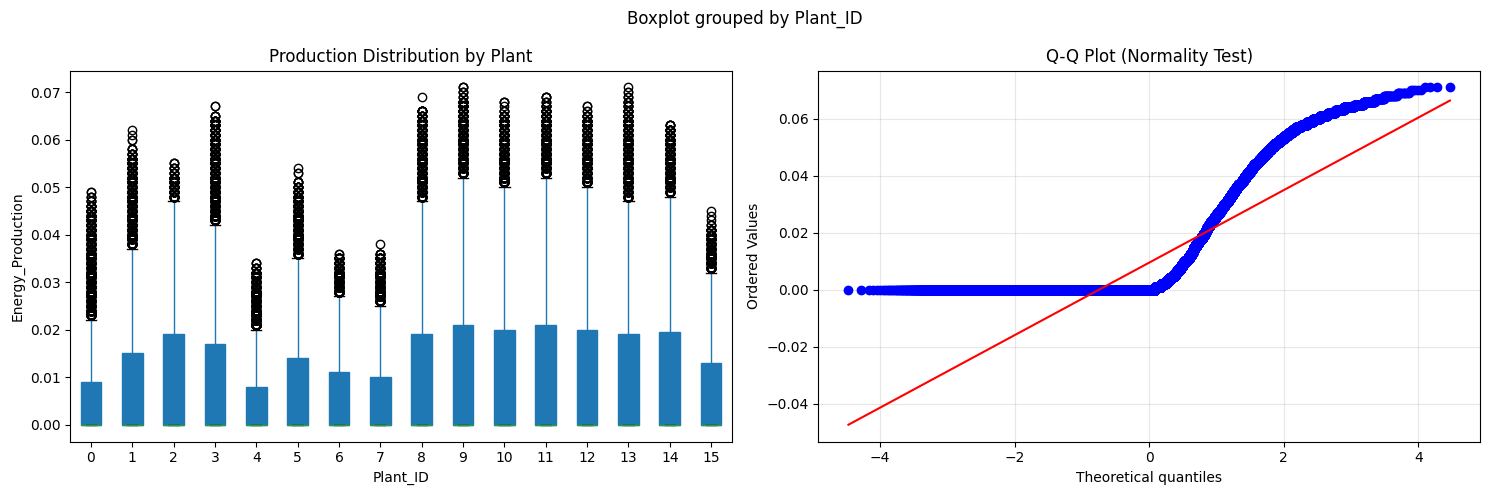


Energy_Production Statistics:
Mean: 0.01
Median: 0.00
Std: 0.02
Min: 0.00
Max: 0.07
Skewness: 1.66
Kurtosis: 1.74


In [ ]:
# Target variable (Energy production) distribution analysis
fig,axes = plt.subplots(1,2,figsize=(15,5))

#Boxplot by plant to compare distributions
train.boxplot(column="Energy_Production", by="Plant_ID", ax=axes[0],patch_artist=True, grid=False)
axes[0].set_title('Production Distribution by Plant')
axes[0].set_xlabel('Plant_ID')
axes[0].set_ylabel('Energy_Production')

# Q-Q plot to test for normality
# Points should follow the diagonal line if data is normally distributed
stats.probplot(train["Energy_Production"], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Normality Test)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Key statistics
print(f"\nEnergy_Production Statistics:")
print(f"Mean: {train['Energy_Production'].mean():.2f}")
print(f"Median: {train['Energy_Production'].median():.2f}")
print(f"Std: {train['Energy_Production'].std():.2f}")
print(f"Min: {train['Energy_Production'].min():.2f}")
print(f"Max: {train['Energy_Production'].max():.2f}")
print(f"Skewness: {train['Energy_Production'].skew():.2f}")
print(f"Kurtosis: {train['Energy_Production'].kurtosis():.2f}")

Energy production is highly skewed and concentrated near zero, whcih indicates night-time periods with no solar generation.  

The Q-Q plot confirms a strong deviation from normality, indicating that linear model assumptions are unlikely to hold in this case.  

This indicates that the use of tree-based and boosting models is required.


## Variable recap

**Categorical / descriptor variables:**
- Day-Night (binary)
- Temperature descriptor  
- Precipitation descriptor  
- Sky descriptor  

**Numerical variables:**
- Comfort level  
- Visibility  
- Probability of precipitation for last hour  
- Rainfall amount for last hour  
- Dew point  
- Temperature  
- Wind direction  
- Humidity  
- Wind speed




Weather features identified: 9


['Comfort level',
 'Visibility',
 'Probability of precipitation for last hour',
 'Rainfall amount for last hour',
 'Dew point',
 'Temperature',
 'Wind direction',
 'Humidity',
 'Wind speed']

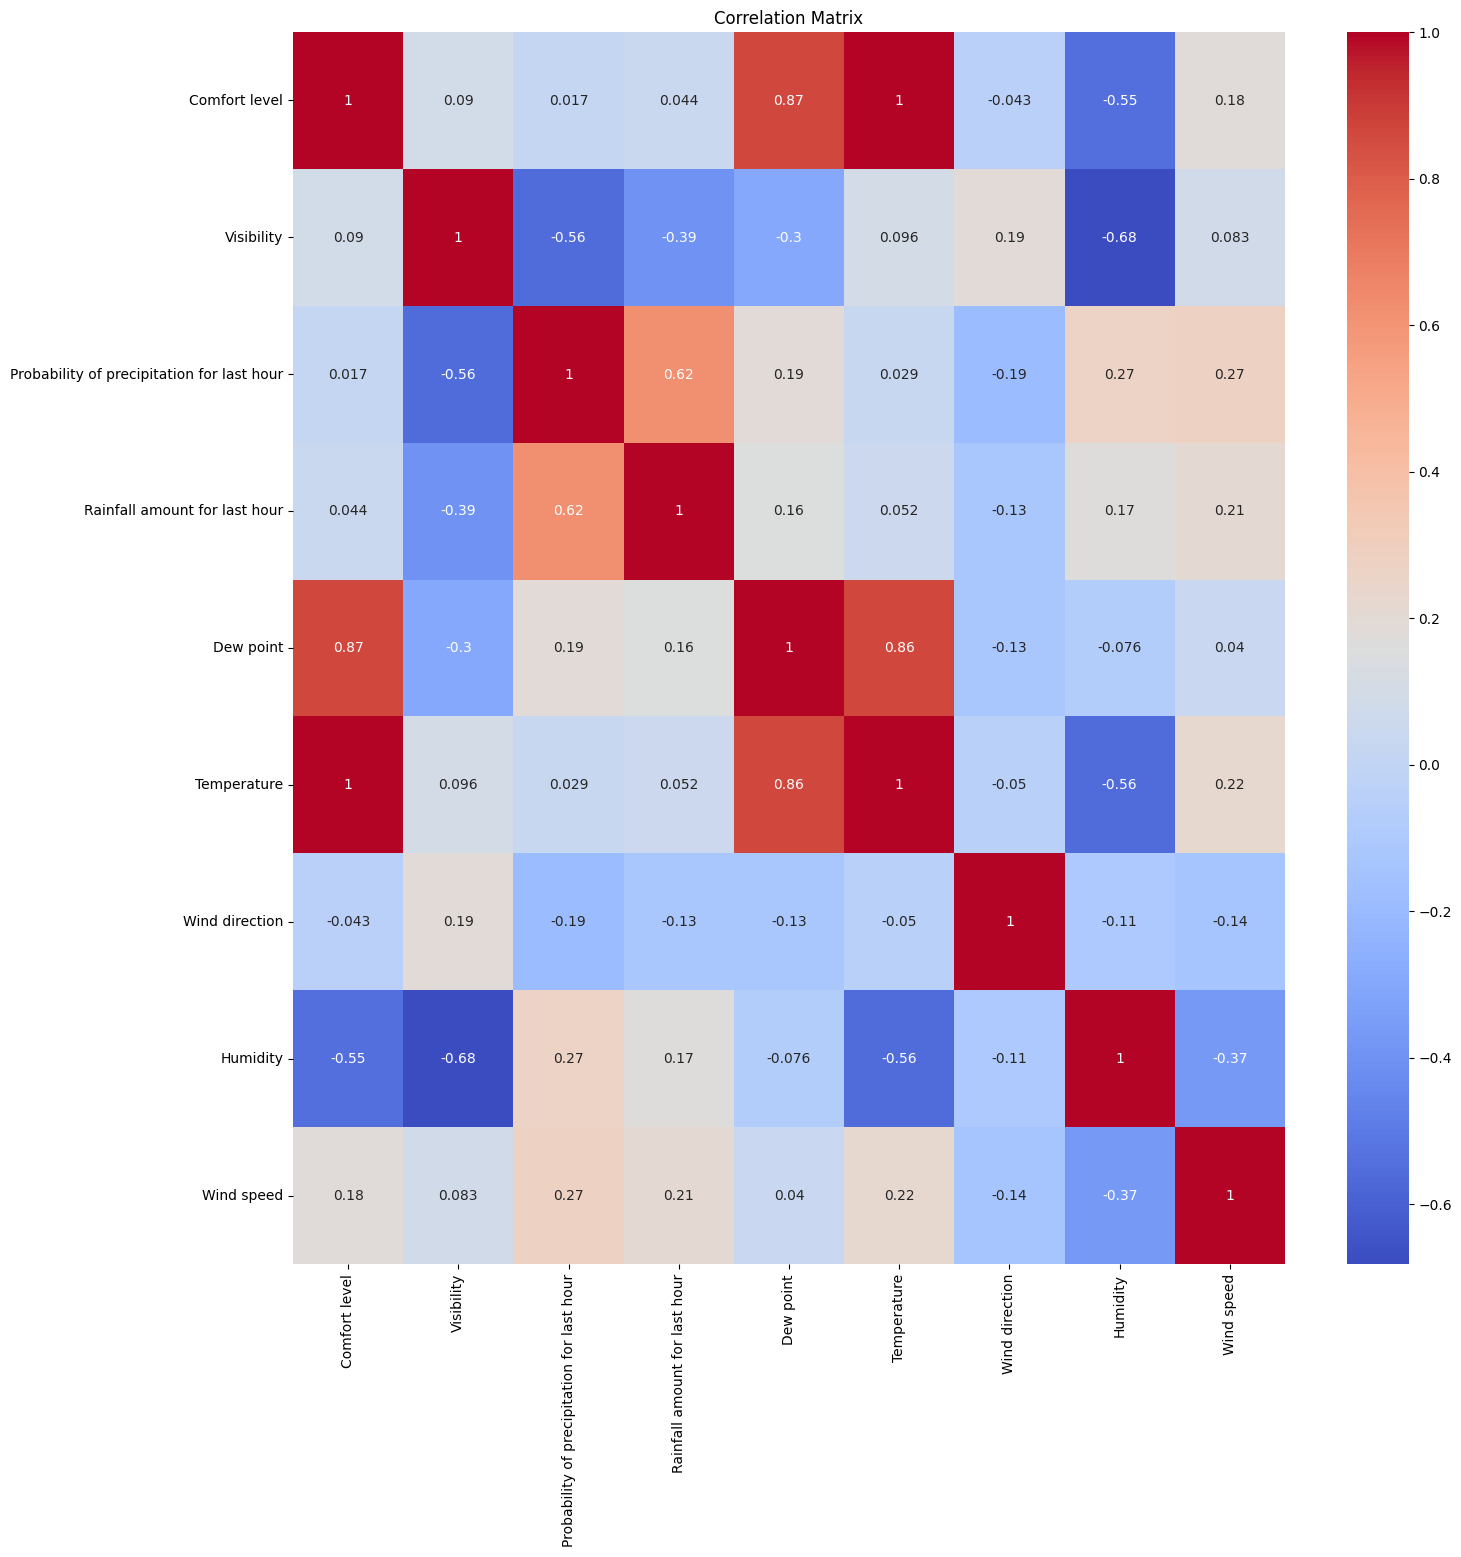

,Feature_1,Feature_2,Correlation
1,Comfort level,Temperature,0.996616
0,Comfort level,Dew point,0.867855
2,Dew point,Temperature,0.864787


In [ ]:
# Correlations between weather variables
# We compute correlations only on continuous numerical weather features because the descriptor variables are categorical codes
# Excluding Plant_ID, Energy_Production and Benchmark

weather_cols = [
    "Comfort level",
    "Visibility",
    "Probability of precipitation for last hour",
    "Rainfall amount for last hour",
    "Dew point",
    "Temperature",
    "Wind direction",
    "Humidity",
    "Wind speed"
]
print(f"Weather features identified: {len(weather_cols)}")
display(weather_cols)

#Correlation matrix
corr_matrix = train[weather_cols].corr()

#Visualisation of correlation matrix with heatmap
fig,ax=plt.subplots(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Matrix')
plt.show()

# Identify highly correlated feature pairs with absolute correlation >0.8 as these pairs can cause multicolinearity issue in linear models
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1,len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i,j]) > 0.8:
          high_corr_pairs.append({"Feature_1":corr_matrix.columns[i],
                                  "Feature_2":corr_matrix.columns[j],
                                  "Correlation":corr_matrix.iloc[i,j]})
display(pd.DataFrame(high_corr_pairs).sort_values("Correlation", key=lambda s: s.abs(), ascending=False).head(20))

The correlation analysis shows strong multicollinearity among temperature-related variables, in particular between temperature, comfort level and dew point. This motivates the use of PCA for linear and distance-based models. Rainfall probability and rainfall amount are also highly correlated. Wind direction shows little linear correlation, which is expected as it has circular nature and so it justifies the use of sine–cosine encoding later.


In [ ]:
# Correlation between weather features and target
target_corr=train[weather_cols+[target_col]].corr()[target_col].drop(target_col)
target_corr=target_corr.sort_values(ascending=False)
target_corr

,Energy_Production
Temperature,0.488400
Comfort level,0.481825
Visibility,0.395889
Wind speed,0.306496
Dew point,0.187473
Wind direction,0.040365
Rainfall amount for last hour,-0.069988
Probability of precipitation for last hour,-0.115765
Humidity,-0.649811


Energy production shows moderate positive correlation with temperature, comfort level and visibility, which indicates higher solar output under warm and clear conditions.

Humidity has a strong negative correlation with energy production, reflecting reduced solar generation during cloudy or humid weather.  


In [ ]:
# Production Variance across plants
variance_analysis=train.groupby("Plant_ID")["Energy_Production"].agg([
    ('Mean','mean'),
    ('Std', 'std'),
    ('Variance', 'var'),
    ('CV', lambda x: x.std() / x.mean() if x.mean() != 0 else 0),  # Coefficient of Variation
    ('Min', 'min'),
    ('Max', 'max'),
    ('Range', lambda x: x.max() - x.min())
]).round(2)
display(variance_analysis)

,Mean,Std,Variance,CV,Min,Max,Range
Plant_ID,,,,,,,
0,0.01,0.01,0.0,1.64,0.0,0.05,0.05
1,0.01,0.01,0.0,1.57,0.0,0.06,0.06
2,0.01,0.02,0.0,1.47,0.0,0.06,0.06
3,0.01,0.02,0.0,1.56,0.0,0.07,0.07
4,0.01,0.01,0.0,1.60,0.0,0.03,0.03
5,0.01,0.01,0.0,1.56,0.0,0.05,0.05
6,0.01,0.01,0.0,1.54,0.0,0.04,0.04
7,0.01,0.01,0.0,1.54,0.0,0.04,0.04
8,0.01,0.02,0.0,1.54,0.0,0.07,0.07


Energy production shows similar average levels across all plants, but variability differs a bit.

The coefficient of variation (CV) is consistently above 1 for all plants, suggesting high relative variability in production over time.

This suggests that temporal effects and plant-specific dynamics are important, justifying the use of lagged features and the inclusion of plant identity in the modelling stage.


In [ ]:
# Outlier detection
# Quartiles and IQR
Q1=train["Energy_Production"].quantile(0.25)
Q3=train["Energy_Production"].quantile(0.75)
IQR=Q3-Q1

# Outlier boundaries
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR

# Identify outliers (value outside the boundaries)
outliers=train[(train["Energy_Production"]<lower_bound) | (train["Energy_Production"]>upper_bound)]

# Display outlier statistics
print(f"\nOutlier Statistics (IQR Method):")
print(f"Q1 (25th percentile): {Q1:.2f}")
print(f"Q3 (75th percentile): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(train)*100:.2f}%)")

# Outliers by plant
outliers_by_plant=outliers.groupby("Plant_ID").size().sort_values(ascending=False)
print("Outliers by plant:")
display(outliers_by_plant)


Outlier Statistics (IQR Method):
Q1 (25th percentile): 0.00
Q3 (75th percentile): 0.01
IQR: 0.01
Lower bound: -0.02
Upper bound: 0.04
Number of outliers: 15374 (8.71%)
Outliers by plant:


,0
Plant_ID,
9,1793
11,1775
10,1613
13,1523
8,1512
12,1502
14,1490
3,1432
1,1043


## Outlier Analysis

Using the IQR method, we see that around 8.7% of observations are flagged as outliers.  

Given the highly skewed and zero-inflated nature of solar energy production (many zero values during night hours), we conclude that these outliers mainly correspond to high production peaks rather than data errors.  

Outliers are unevenly distributed across plants, suggesting differences in capacity or environmental conditions.  



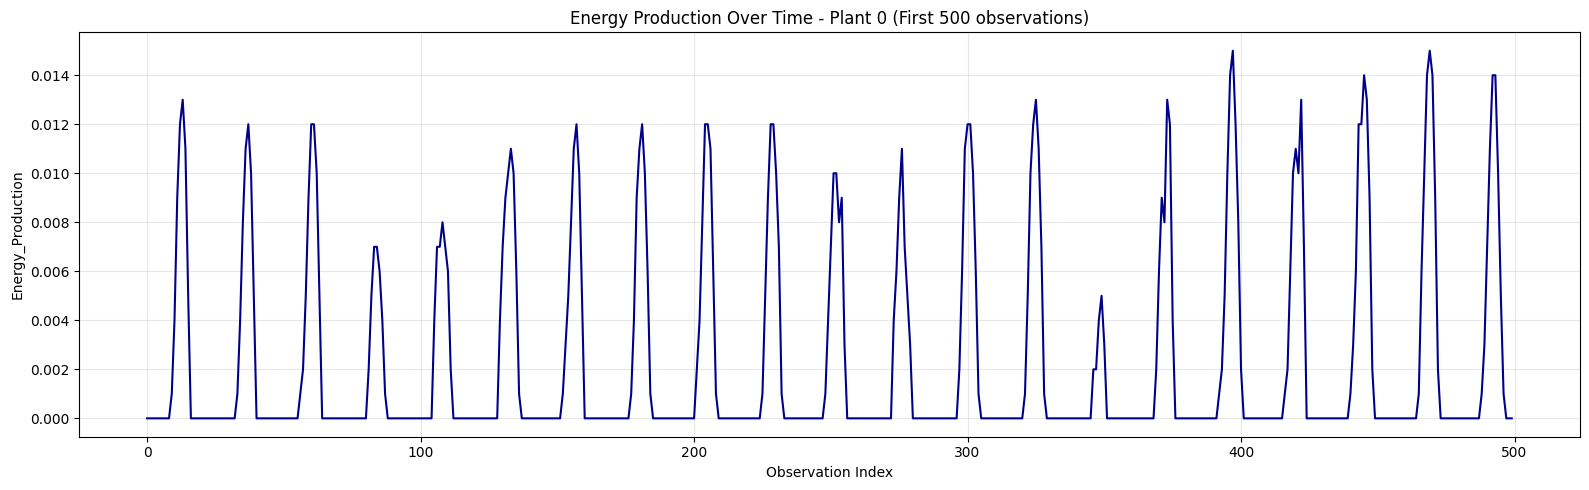

In [ ]:
# Time series analysis (to identify trend, seasonality, patterns)
sample_plant=train["Plant_ID"].unique()[0]
sample_data=train[train["Plant_ID"]==sample_plant].head(500)

fig, ax = plt.subplots(figsize=(16, 5))
ax.plot(sample_data.index, sample_data['Energy_Production'], linewidth=1.5, color='darkblue')
ax.set_title(f'Energy Production Over Time - Plant {sample_plant} (First 500 observations)')
ax.set_xlabel('Observation Index')
ax.set_ylabel('Energy_Production')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The time series plot for a single plant shows a strong daily seasonality pattern, with energy production peaking during daytime hours and remaining close to zero at night.  

There is no visible long-term trend over this short horizon, but the amplitude of daily peaks varies slightly, which suggests a dependence on weather conditions.

These observations motivate the inclusion of lag features (eg. 1h, 24h, 48h) and cyclical time features (hour of day) in the feature engineering stage.


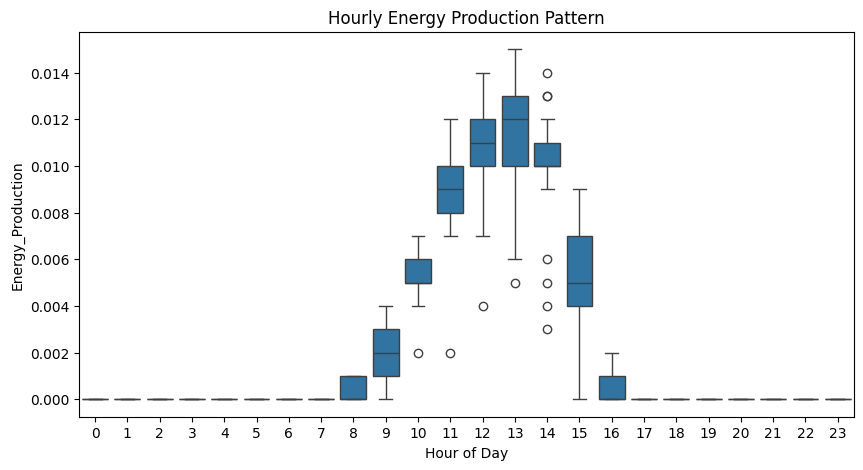

In [ ]:
# Intraday (hourly) Seasonality

sample_data = sample_data.copy()
sample_data["hour"] = sample_data[time_col].dt.hour

plt.figure(figsize=(10, 5))
sns.boxplot(x="hour", y=target_col, data=sample_data)
plt.title("Hourly Energy Production Pattern")
plt.xlabel("Hour of Day")
plt.ylabel("Energy_Production")
plt.show()



The boxplot of energy production by hour of day highlights a strong intraday seasonality pattern.

It can be seen that production is zero during night hours and increases rapidly after sunrise, peaks around midday and declines in the afternoon.

This confirms that time-of-day information is an important driver of solar energy production and motivates the use of cyclical hour features (sine and cosine encoding) for modelling.


<Figure size 1000x600 with 0 Axes>

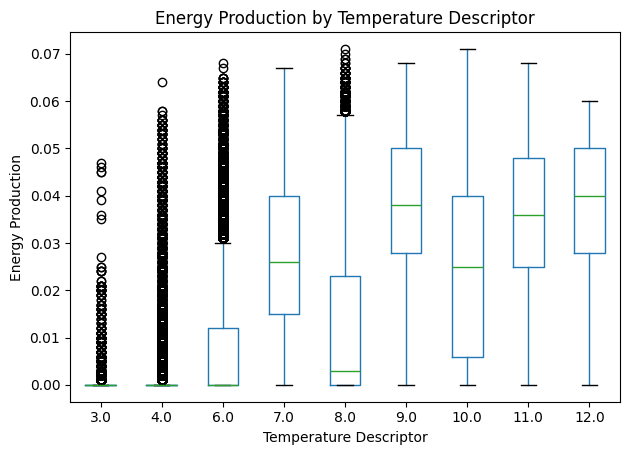

In [ ]:
# Boxplot to explore relationship between Energy Production and temperature descriptor (ordinal variable)
plt.figure(figsize=(10, 6))
train.boxplot(column=target_col, by="Temperature descriptor", grid=False)
plt.title("Energy Production by Temperature Descriptor")
plt.suptitle("")
plt.xlabel("Temperature Descriptor")
plt.ylabel("Energy Production")
plt.tight_layout()
plt.show()


**Energy Production vs Temperature Descriptor**

The temperature descriptor shows positive relationship with energy production. Higher temperature categories are associated with higher median production, while lower categories correspond mostly to zero or very low output.


# 2. FEATURE ENGINEERING

In [ ]:
# Transformation into dummy (as it is a binary variable D/N)
train["Day-Night"] = (train["Day-Night"] == "D").astype(int)
test["Day-Night"]  = (test["Day-Night"]  == "D").astype(int)
# Day as 1 and Night as 0

In [ ]:
# Cyclical features
def cyclical_features(df):
  """
  Creates cyclical features for time-based.and wind direction
  Uses sin/cos to encode hour, day, month.
  """
  df=df.copy()

  df["hour"]=df[time_col].dt.hour
  df["day"]=df[time_col].dt.day
  df["month"]=df[time_col].dt.month
  df["year"]=df[time_col].dt.year
  df["day_of_week"]=df[time_col].dt.dayofweek
  df['day_of_year'] = df[time_col].dt.dayofyear

  # For hour of a day (24h)
  df['hour_sin'] = np.sin(2 * np.pi*df['hour']/24) # 24 hours cycles
  df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)

  # Day of year(1-365)
  df['day_sin']=np.sin(2*np.pi*df['day_of_year']/365) # anual cycle
  df['day_cos']=np.cos(2*np.pi*df['day_of_year']/365)

  # Month of year (1-12)
  df['month_sin']=np.sin(2*np.pi*df['month']/12) # month cycle
  df['month_cos']=np.cos(2*np.pi*df['month']/12)

  # Day of week (0-6)
  df['day_of_week_sin']=np.sin(2*np.pi*df['day_of_week']/7) # weekly cycle
  df['day_of_week_cos']=np.cos(2*np.pi*df['day_of_week']/7)

  # Wind direction to 360 Dg
  df["wind_dir_sin"] = np.sin(2*np.pi*df["Wind direction"]/360)
  df["wind_dir_cos"] = np.cos(2*np.pi*df["Wind direction"]/360)


  return df

train=cyclical_features(train)
test=cyclical_features(test)


### Cyclical Feature Encoding

Several time-related variables (hour, day of year, month, day of week) and wind direction are cyclical.  

Using raw integer values would incorrectly create a linear structure (eg. hour 23 being far from hour 0).

To preserve the circular or nonlinear relationships, these variables are encoded using sine and cosine transformations.

This allows machine learning models to capture periodic patterns such as daily and seasonal cycles, as well as wind direction.


In [ ]:
# Lag and rolling features (for panel data safety)
def lag_features(df, lags=[1,2,3,24,48,168]):
  df_copy=df.copy()
  for lag in lags:
    df_copy[f'Energy_Production_lag_{lag}'] = df_copy.groupby("Plant_ID")["Energy_Production"].shift(lag)
  return df_copy
# for each plant, a production column with lag
def rolling_features(df, windows=[3,6,12,24]):
  df_copy=df.copy()

  for window in windows:
        # Rolling mean (shift(1) ensures only past information is used)
        df_copy[f"Energy_Production_rolling_mean_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())

        # Rolling standard deviation
        df_copy[f"Energy_Production_rolling_std_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).std().fillna(0))

        # Rolling min and max
        df_copy[f"Energy_Production_rolling_min_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).min())
        df_copy[f"Energy_Production_rolling_max_{window}"] = df_copy.groupby("Plant_ID")["Energy_Production"].transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=1).max())

  return df_copy


## Lag and Rolling Features

Energy production shows strong temporal dependence and seasonality (daily/weakly).

To capture these dynamics, lagged values of energy production are created for a few horizons (1, 2, 3, 24, 48, 168 hours).

Rolling statistics (mean, standard deviation, minimum, maximum) are also computed using past observations only.  
All lag and rolling features are generated separately for each plant using `groupby(Plant_ID)`, and a one-step shift is applied before rolling to prevent data leakage.

In [ ]:
# Dummy to fix separation before concatenate
train["_is_train"] = 1
test["_is_train"]  = 0


In [ ]:
# Join both datasets by order
full = pd.concat([train, test], ignore_index=True)
full = full.sort_values(["Plant_ID", time_col]).reset_index(drop=True)

# Apply function
full = lag_features(full, lags=[1,2,3,24,48,168])
full = rolling_features(full, windows=[3,6,12,24])

# Separation
train = full[full["_is_train"] == 1].drop(columns=["_is_train"]).reset_index(drop=True)
test  = full[full["_is_train"] == 0].drop(columns=["_is_train"]).reset_index(drop=True)
new_features=[col for col in train.columns if col not in ["Plant_ID","UTC Time", "Energy_Production", 'Day-Night']+weather_cols]
print(f"New features created:{len(new_features)}")


New features created:42


In [ ]:
# fill lags nan (with median only in train)
lag_roll_cols = [c for c in train.columns if ("_lag_" in c) or ("_rolling_" in c)]
med = train[lag_roll_cols].median()
train[lag_roll_cols] = train[lag_roll_cols].fillna(med)
test[lag_roll_cols]  = test[lag_roll_cols].fillna(med)

Recap new features until here:


**To each plant:**
*   Energy_Production_lag_1,2,3,24...

**Rolling features-energy production**
*   Window 3,6,12,24

**Time features**
*   hour sin-cos/day/month/dayweek/


**Wind direction**







In [ ]:
# Preserve original Plant_ID for filtering and local models

train["Plant_ID_raw"] = train["Plant_ID"]
test["Plant_ID_raw"]  = test["Plant_ID"]

### Categorical encoding and missing-category handling

Several variables are categorical (plant identity and weather descriptors). Since most ML models require numeric inputs, these variables are transformed here using **One-Hot Encoding**.

We also explicitly create a `*_nan` category to capture missing values as an informative signal (eg. unknown weather descriptor). This avoids dropping rows and lets the model learn whether “missing” carries meaning.


In [ ]:
# ONE HOT Encoding for our categorical variables
cat_cols = ["Plant_ID", "Precipitation descriptor", "Sky descriptor"]

train = pd.get_dummies(train, columns=cat_cols, dummy_na=True)
test  = pd.get_dummies(test,  columns=cat_cols, dummy_na=True)

X_cols = [c for c in train.columns if c not in ["Energy_Production","Benchmark","UTC Time","Plant_ID_raw"]]
test = test.reindex(columns=X_cols + ["Benchmark","UTC Time","Plant_ID_raw"], fill_value=0)


In [ ]:
list(train.columns)

['UTC Time',
 'Energy_Production',
 'Benchmark',
 'Day-Night',
 'Temperature descriptor',
 'Comfort level',
 'Visibility',
 'Probability of precipitation for last hour',
 'Rainfall amount for last hour',
 'Dew point',
 'Temperature',
 'Wind direction',
 'Humidity',
 'Wind speed',
 'hour',
 'day',
 'month',
 'year',
 'day_of_week',
 'day_of_year',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'wind_dir_sin',
 'wind_dir_cos',
 'Energy_Production_lag_1',
 'Energy_Production_lag_2',
 'Energy_Production_lag_3',
 'Energy_Production_lag_24',
 'Energy_Production_lag_48',
 'Energy_Production_lag_168',
 'Energy_Production_rolling_mean_3',
 'Energy_Production_rolling_std_3',
 'Energy_Production_rolling_min_3',
 'Energy_Production_rolling_max_3',
 'Energy_Production_rolling_mean_6',
 'Energy_Production_rolling_std_6',
 'Energy_Production_rolling_min_6',
 'Energy_Production_rolling_max_6',
 'Energy_Production_rolling_mean_12',

In [ ]:
train[["Plant_ID_nan","Precipitation descriptor_nan","Sky descriptor_nan"]].sum()
train = train.drop(columns=["Plant_ID_nan", "Sky descriptor_nan"])
test  = test.drop(columns=["Plant_ID_nan",  "Sky descriptor_nan"])


### Sanity checks and handling of “NaN dummy” columns

We run a few quick checks to ensure:
- the expected engineered features (lags/rolling) are present,
- the one-hot encoded columns were created correctly,
- train/test columns are aligned.

We also inspect the `*_nan` dummy columns. If a `*_nan` column is always 0 (i.e., no missing values for that category in the dataset), it carries no information and can be safely dropped to reduce dimensionality.


In [ ]:
# Split 30%-70% With time
def panel_time_split(df, plant_col, time_col,val_ratio=0.3):
  df=df.sort_values([plant_col,time_col]).copy()
  train_parts,val_parts=[],[]
  for pid, sub in df.groupby(plant_col):
    cut=int(len(sub)*(1-val_ratio))
    train_parts.append(sub.iloc[:cut])
    val_parts.append(sub.iloc[cut:])
  return pd.concat(train_parts), pd.concat(val_parts)

train_df,val_df=panel_time_split(train,"Plant_ID_raw", time_col,0.3)
X_train_orig = train_df.drop(columns=[target_col, "Benchmark", time_col]) #features (X) in train_df
y_train = train_df[target_col] #target (y) in train_df

X_val_orig = val_df.drop(columns=[target_col, "Benchmark", time_col])#features (X) in val_df.
y_val = val_df[target_col] # target in val_df

### Time-aware train/validation split (panel data)

Because this is a time series / panel dataset, we must avoid randomly shuffling observations.
We split chronologically within each plant: the earliest (≈70%) observations are used for training and the latest (≈30%) for validation.

This preserves the real forecasting setting and prevents leakage (as the model must not “see the future” of a given plant during training).


In [ ]:
#Dimensionality reduction (PCA)
weather_features = [c for c in weather_cols if c in X_train_orig.columns and c != "Wind direction"]
weather_features
print(f"Number of original weather features for PCA: {len(weather_features)}")

#Add transformed wind direction into weather features
for c in ["wind_dir_sin","wind_dir_cos"]:
  if c in X_train_orig.columns:
    weather_features.append(c)

Number of original weather features for PCA: 8


### PCA on Weather Features (Dimensionality Reduction)

Weather variables are often highly correlated (e.g. temperature, comfort level, dew point), which can negatively impact linear and distance-based models due to multicollinearity.

To address this issue, Principal Component Analysis (PCA) is applied only to the weather-related numerical features, after standardization.  

Non-weather variables (including lagged energy production, rolling statistics, time features, and categorical encodings) are kept in their original form.

PCA allows us to compress the weather information into a smaller number of uncorrelated components while preserving most of the variance.  

Based on the explained variance analysis, the first components capturing approximately **95% of total variance** are retained.


In [ ]:
# Standardize the weather features
scaler = StandardScaler()

# Fit scaler on training weather features only
Xtr_w = scaler.fit_transform(X_train_orig[weather_features])

# Fit PCA with all components to analyze explained variance
pca_full = PCA()
pca_full.fit(Xtr_w)

# Explained variance ratio
explained = pca_full.explained_variance_ratio_
cumulative = np.cumsum(explained)

print("Explained Variance by Component:")
for i, (var, cum) in enumerate(zip(explained, cumulative)):
    print(
        f"PC{i+1}: {var:.4f} ({var*100:.2f}%) | "
        f"Cumulative: {cum:.4f} ({cum*100:.2f}%)"
    )


Continuous weather variables are standardized prior to PCA to ensure that all features contribute on a comparable scale. PCA components are then concatenated with the remaining engineered features to form an alternative feature set for model comparison.


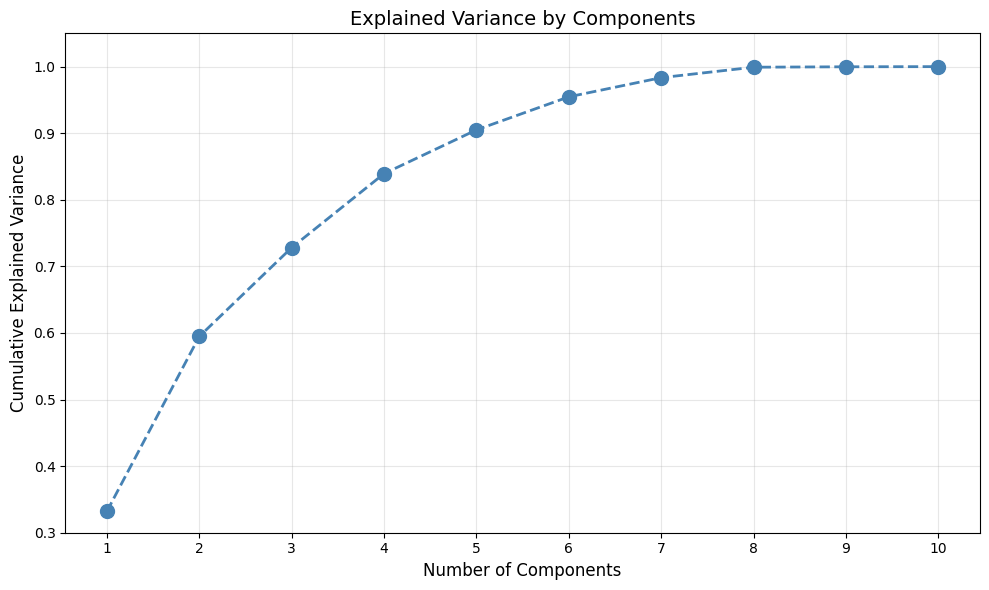


Components needed for 90% variance: 5
Components needed for 95% variance: 6


In [ ]:
# Plot Explained Variance by Components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative)+1), cumulative, 'o--',
         color='steelblue', linewidth=2, markersize=10)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Components', fontsize=14)
plt.xticks(range(1, len(cumulative)+1))
plt.ylim(0.3, 1.05)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find number of components for 90% and 95% variance
n_components_95 = np.argmax(cumulative >= 0.95) + 1
n_components_90 = np.argmax(cumulative >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")

### Interpreting the explained variance curve

The cumulative explained variance curve helps choose a compact number of principal components while keeping most of the original information.

We select `k = n_components_95` (printed above), meaning we retain enough PCA components to preserve **about 95% of the total variance** in weather features.
This is a common trade-off: strong compression with limited information loss, while reducing noise and multicollinearity.


In [ ]:
# define k
k = n_components_95
k

np.int64(6)

In [ ]:
# Create the pca components
Xval_w = scaler.transform(X_val_orig[weather_features])
Xtest_w = scaler.transform(test[weather_features])

pca = PCA(n_components=k, random_state=42)
Xtr_pc = pca.fit_transform(Xtr_w)
Xval_pc = pca.transform(Xval_w)
Xtest_pc = pca.transform(Xtest_w)

pc_cols = [f"PCA_{i+1}" for i in range(k)]

In [ ]:
# final datasets considering the pca elements created
other_cols = [c for c in X_train_orig.columns if c not in weather_features]

X_train_pca = pd.concat([X_train_orig[other_cols].reset_index(drop=True),
                         pd.DataFrame(Xtr_pc, columns=pc_cols)], axis=1)

X_val_pca = pd.concat([X_val_orig[other_cols].reset_index(drop=True),
                       pd.DataFrame(Xval_pc, columns=pc_cols)], axis=1)

test_with_pca = pd.concat([test[other_cols].reset_index(drop=True),
                           pd.DataFrame(Xtest_pc, columns=pc_cols)], axis=1)

X_train_orig.shape, X_train_pca.shape, X_val_orig.shape, X_val_pca.shape


((123546, 103), (123546, 99), (52959, 103), (52959, 99))

A PCA-based feature set is constructed by replacing raw weather variables with principal components while keeping the remaining engineered features unchanged. This enables a controlled comparison between the original and reduced feature representations.


### Variable Naming Recap

To improve readability in the modeling section, the main datasets are summarised below:

- **X_train_orig / X_val_orig**: Feature matrices using original engineered features  
- **X_train_pca / X_val_pca**: Feature matrices using PCA-transformed weather features  
- **X_test_orig / X_test_pca**: Feature matrices for the test period  

Target variables:
- **y_train**, **y_val**: Energy production targets for training and validation  
- **y_test**: True energy production values for the test set (used only for final evaluation)


# 3. Model Selection & Tuning:

In [ ]:
from sklearn.base import clone

SCALE_MODELS={"Ridge","Lasso","KNN"}
def train_and_evaluate(X_train, y_train, X_val, y_val, models_dict,scale_models=SCALE_MODELS):
    results = {}

    #fit scaler only if we actually have models that need scaling
    need_scaling=any(name in scale_models for name in models_dict)
    if need_scaling:
        scaler=StandardScaler()
        X_train_scaled=scaler.fit_transform(X_train)
        X_val_scaled=scaler.transform(X_val)

    for model_name, model in models_dict.items():
        m=clone(model)

        if need_scaling and model_name in scale_models:
          Xtr_use,Xva_use=X_train_scaled,X_val_scaled
        else:
          Xtr_use,Xva_use=X_train,X_val

        m.fit(Xtr_use, y_train)

        train_preds = np.clip(m.predict(Xtr_use), 0, None)
        val_preds   = np.clip(m.predict(Xva_use),   0, None)

        results[model_name] = {
            "Train_RMSE": np.sqrt(mean_squared_error(y_train,train_preds)),
            "Val_RMSE": np.sqrt(mean_squared_error(y_val,val_preds)),
            "Train_R2": r2_score(y_train,train_preds),
            "Val_R2": r2_score(y_val,val_preds),
            "Val_Preds": val_preds,
            "Model": m
        }
    return results


### Comparing models on original features vs PCA-compressed weather features

We train the same set of models twice:
- using the original engineered feature set,
- using the version where weather information is compressed into PCA components.

This allows us to test whether PCA improves generalization and/or reduces computation cost, while keeping the rest of the pipeline identical.


In [ ]:
#Models to train
models = {
    'Ridge': Ridge(alpha=1, random_state=42),
    'Lasso': Lasso(alpha=0.1,max_iter=5000,random_state=42),
    'KNN': KNeighborsRegressor(n_neighbors=25),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    #"AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42, algorithm='SAMME'),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, eval_metric='rmse'),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
}

results_orig = train_and_evaluate(X_train_orig, y_train, X_val_orig, y_val, models)
results_pca  = train_and_evaluate(X_train_pca,  y_train, X_val_pca,  y_val, models)


### Computational Performance Comparison

| Model             | Fit time (Original) | Predict time (Original) | Fit time (PCA) | Predict time (PCA) |
| ----------------- | ------------------: | ----------------------: | -------------: | -----------------: |
| Ridge             |              0.48 s |                  0.05 s |         0.13 s |             0.02 s |
| Lasso             |              0.36 s |                  0.06 s |         0.16 s |             0.03 s |
| KNN               |              0.15 s |            **210.64 s** |         0.08 s |       **192.26 s** |
| Random Forest     |        **343.59 s** |                  3.66 s |   **329.89 s** |             3.22 s |
| Gradient Boosting |             78.57 s |                  0.40 s |        78.57 s |             0.39 s |
| XGBoost           |              3.43 s |                  0.94 s |         2.91 s |             0.57 s |
| **LightGBM**      |          **2.89 s** |              **0.72 s** |     **2.34 s** |         **0.69 s** |


In addition to predictive accuracy, we compare models based on training and inference time.
Linear models (Ridge, Lasso) are extremely fast but provide limited predictive performance.
KNN exhibits prohibitively slow inference time, making it unsuitable for practical deployment.
Random Forest and Gradient Boosting incur high training costs.
XGBoost and LightGBM achieve the best balance between accuracy and computational efficiency, with LightGBM being the fastest overall.
PCA slightly reduces computation time but does not materially change the ranking of models.



In [ ]:
#results to df for a clean comparison table
def results_to_df(results, feature_set):
  rows=[]

  for name, d in results.items():
    rows.append({
        "Model":name,
        "Features":feature_set,
        "Train_RMSE":d["Train_RMSE"],
        "Val_RMSE":d["Val_RMSE"],
        "Train_R2":d["Train_R2"],
        "Val_R2":d['Val_R2']
    })
  return pd.DataFrame(rows)

res_df=results_to_df(results_orig, "Original")
res_pca_df=results_to_df(results_pca, "PCA")
scores=pd.concat([res_df,res_pca_df]).sort_values("Val_RMSE").reset_index(drop=True)


In [ ]:
scores

,Model,Features,Train_RMSE,Val_RMSE,Train_R2,Val_R2
0,LightGBM,PCA,0.002219,0.002903,0.981158,0.951069
1,LightGBM,Original,0.002204,0.002912,0.981418,0.950753
2,RandomForest,Original,0.000685,0.002981,0.998203,0.948414
3,GradientBoosting,Original,0.003119,0.002990,0.962788,0.948103
4,RandomForest,PCA,0.000690,0.002994,0.998178,0.947969
5,GradientBoosting,PCA,0.003115,0.003015,0.962883,0.947207
6,XGBoost,PCA,0.001516,0.003055,0.991204,0.945799
7,XGBoost,Original,0.001548,0.003137,0.990827,0.942858
8,Ridge,PCA,0.003515,0.003181,0.952736,0.941269
9,Ridge,Original,0.003514,0.003184,0.952752,0.941158


### Takeaway from model selection

Overall, **LightGBM** provides the strongest validation performance while remaining computationally efficient.
In our experiments, applying PCA to weather features does **not** significantly improve predictive accuracy, suggesting that the original engineered features already capture the relevant weather signal (or that PCA compresses some useful variability).

We therefore select LightGBM as the main candidate for the final model.


# Local Models


In [ ]:
#Function to apply light model to each plant
def train_evaluate_lgbm_local(X_train, y_train, X_val, y_val):
    """
    Trains and evaluates a LightGBM model for a single plant.
    Returns validation RMSE and R2 scores.
    """
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_train, y_train)

    val_preds = model.predict(X_val)
    val_preds = np.clip(val_preds, 0, None) # Ensure non-negative predictions

    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    r2 = r2_score(y_val, val_preds)
    return rmse, r2



In [ ]:
# create a list to store local results (one model per plant)
local_model_results = []

# get the unique plant ids from the raw plant id column
unique_plant_ids = sorted(X_train_orig["Plant_ID_raw"].dropna().unique())

# drop the id columns because in a local model we already know the plant
plant_id_cols_to_drop = ["Plant_ID_raw"] + [c for c in X_train_orig.columns if c.startswith("Plant_ID_")]

# loop over each plant and train a separate model
for plant_id in unique_plant_ids:

    # filter train set for this plant
    X_train_plant = X_train_orig[X_train_orig["Plant_ID_raw"] == plant_id].copy()
    y_train_plant = y_train[X_train_orig["Plant_ID_raw"] == plant_id].copy()

    # filter validation set for this plant
    X_val_plant = X_val_orig[X_val_orig["Plant_ID_raw"] == plant_id].copy()
    y_val_plant = y_val[X_val_orig["Plant_ID_raw"] == plant_id].copy()

    # drop Plant_ID-related columns from both sets
    X_train_plant_filtered = X_train_plant.drop(columns=plant_id_cols_to_drop, errors="ignore")
    X_val_plant_filtered   = X_val_plant.drop(columns=plant_id_cols_to_drop, errors="ignore")

    # align validation columns to training columns (avoid column mismatch errors)
    X_val_plant_filtered = X_val_plant_filtered.reindex(columns=X_train_plant_filtered.columns, fill_value=0)

    # train + evaluate the local LightGBM model for this plant
    rmse, r2 = train_evaluate_lgbm_local(
        X_train_plant_filtered, y_train_plant,
        X_val_plant_filtered,   y_val_plant
    )

    # store results
    local_model_results.append({
        "Plant_ID": plant_id,
        "Val_RMSE": rmse,
        "Val_R2": r2,
        "n_val": len(y_val_plant)
    })


local_results_df = pd.DataFrame(local_model_results).sort_values("Val_RMSE")
display(local_results_df)


,Plant_ID,Val_RMSE,Val_R2,n_val
4,4,0.001548,0.945498,3449
7,7,0.001687,0.948481,3449
6,6,0.001780,0.947849,3449
15,15,0.002312,0.943800,3449
0,0,0.002372,0.941492,3449
5,5,0.002531,0.948159,3449
1,1,0.002836,0.943911,3449
3,3,0.003022,0.940905,3449
8,8,0.003256,0.950425,3449
12,12,0.003348,0.946608,3449


### Interpretation of Local Model Results

The per-plant LightGBM evaluation shows strong and relatively homogeneous performance across most power plants, with validation R² values consistently above 0.94.

One exception is Plant 2, which exhibits higher RMSE and lower R². This plant also has fewer validation observations, which may partly explain the reduced performance. The results suggest that while plant-specific dynamics exist, the overall behavior of the plants is sufficiently similar to justify a global modeling approach.

This analysis supports the use of a global model, possibly complemented by plant-specific calibration if required.


In [ ]:
bench_preds = val_df["Benchmark"].values
# errors
rmse_bench = np.sqrt(mean_squared_error(y_val, bench_preds))
r2_bench   = r2_score(y_val, bench_preds)


### Benchmark comparison

We compare our model against the provided **benchmark** on the same validation set.
This gives a clear reference point: the ML pipeline is only valuable if it improves upon the benchmark in terms of error (RMSE) and explanatory power (R²).


In [ ]:
drop_raw = ["Plant_ID_raw"]  # keep one-hot Plant_ID_*, drop raw id

X_train_final = X_train_orig.drop(columns=drop_raw, errors="ignore")
X_val_final   = X_val_orig.drop(columns=drop_raw, errors="ignore")

# Build test features
X_test_orig = test.drop(columns=["Benchmark", time_col, "Plant_ID_raw"], errors="ignore")
X_test_final = X_test_orig.copy()

# Align columns
X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)
X_val_final  = X_val_final.reindex(columns=X_train_final.columns, fill_value=0)

print(X_train_final.shape, X_val_final.shape, X_test_final.shape)


(123546, 102) (52959, 102) (59376, 102)


### Final feature alignment before training the final model

Before training the final model and generating test predictions, we ensure that:
- non-numeric or raw identifier columns are removed,
- train/validation/test share the exact same feature columns.

This step prevents shape mismatches and guarantees that the model receives the same feature structure at inference time.


In [ ]:
X_full = pd.concat([X_train_final, X_val_final], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

final_model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
final_model.fit(X_full, y_full)


LGBMRegressor(random_state=42, verbose=-1)

In [ ]:
# Final evaluation on validation (numeric comparison vs benchmark)
val_preds = np.clip(final_model.predict(X_val_final), 0, None)

rmse_val_model = np.sqrt(mean_squared_error(y_val, val_preds))
r2_val_model   = r2_score(y_val, val_preds)

bench_val = val_df["Benchmark"].values
rmse_val_bench = np.sqrt(mean_squared_error(y_val, bench_val))
r2_val_bench   = r2_score(y_val, bench_val)

rmse_impr_pct = 100 * (rmse_val_bench - rmse_val_model) / rmse_val_bench

print(f"MODEL on VAL     | RMSE: {rmse_val_model:.4f} | R2: {r2_val_model:.4f}")
print(f"BENCHMARK on VAL | RMSE: {rmse_val_bench:.4f} | R2: {r2_val_bench:.4f}")
print(f"RMSE improvement vs Benchmark (VAL): {rmse_impr_pct:.2f}%")


MODEL on VAL     | RMSE: 0.0022 | R2: 0.9724
BENCHMARK on VAL | RMSE: 0.0066 | R2: 0.7485
RMSE improvement vs Benchmark (VAL): 66.90%


### Validation Performance vs Benchmark

On the validation set, the selected LightGBM model significantly outperforms the provided benchmark.

- The model achieves an RMSE of **0.0022**, compared to **0.0066** for the benchmark, corresponding to a **66.9% reduction in prediction error**.
- The R² score increases from **0.75** (benchmark) to **0.97**, indicating that the model explains a much larger share of the variability in energy production.

These results demonstrate that the machine learning model captures both temporal dynamics and weather-driven effects more effectively than the baseline approach. The substantial improvement over the benchmark confirms the added value of the proposed feature engineering and modelling strategy.


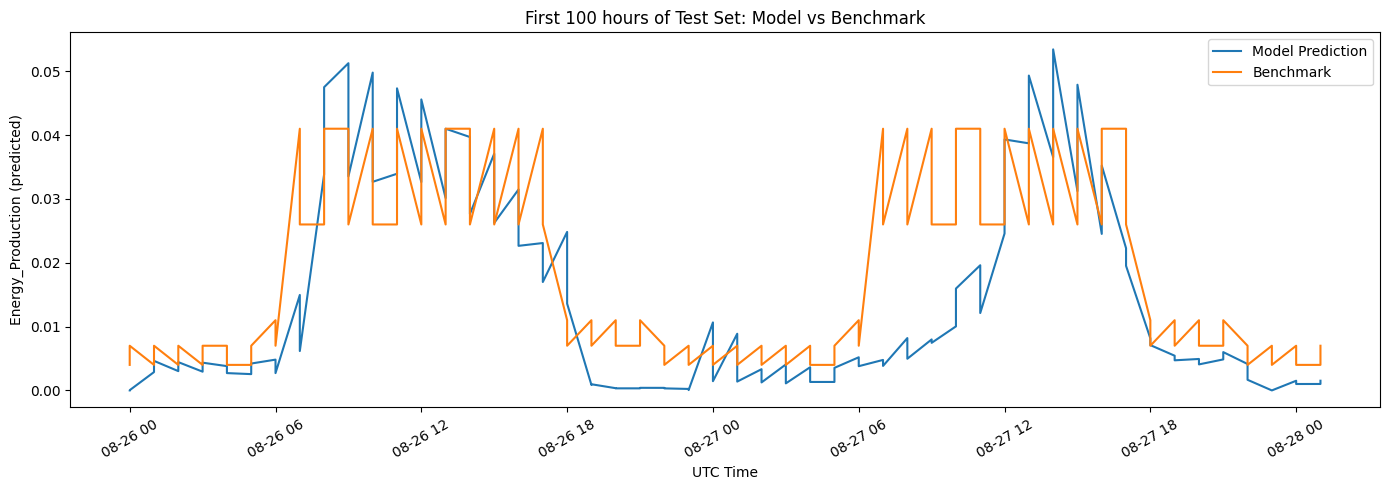

In [ ]:
# Predict on test and compare visually to benchmark
test_preds = np.clip(final_model.predict(X_test_final), 0, None)

plot_df = test[[time_col, "Benchmark"]].copy()
plot_df["Pred"] = test_preds
plot_df = plot_df.sort_values(time_col).reset_index(drop=True)

first_100 = plot_df.head(100)

plt.figure(figsize=(14, 5))
plt.plot(first_100[time_col], first_100["Pred"], label="Model Prediction")
plt.plot(first_100[time_col], first_100["Benchmark"], label="Benchmark")
plt.title("First 100 hours of Test Set: Model vs Benchmark")
plt.xlabel("UTC Time")
plt.ylabel("Energy_Production (predicted)")
plt.xticks(rotation=30)
plt.legend()
plt.tight_layout()
plt.show()


### Visual Comparison: Model vs Benchmark (Test Set)

The figure compares the model predictions and the benchmark over the first 100 hours of the test period.  
Both series follow the same daily production pattern, confirming that the model respects the underlying structure of solar generation.

Compared to the benchmark, the model reacts more smoothly during ramp-up and ramp-down phases and better tracks peak production levels. This suggests that the model captures additional dynamics beyond the baseline approach.

Overall, the visual comparison supports the quantitative results: the model remains stable and provides a closer approximation to true energy production than the benchmark.


In [ ]:
from sklearn.inspection import permutation_importance

X_pi = X_val_final.sample(n=min(5000, len(X_val_final)), random_state=42)
y_pi = y_val.loc[X_pi.index]

perm = permutation_importance(
    final_model, X_pi, y_pi,
    n_repeats=5, random_state=42,
    scoring="neg_root_mean_squared_error"
)

pi_df = pd.DataFrame({
    "feature": X_pi.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

display(pi_df.head(20))


,feature,importance
27,Energy_Production_lag_1,0.011712
11,hour,0.002200
30,Energy_Production_lag_24,0.000925
34,Energy_Production_rolling_std_3,0.000579
32,Energy_Production_lag_168,0.000391
31,Energy_Production_lag_48,0.000365
28,Energy_Production_lag_2,0.000319
4,Probability of precipitation for last hour,0.000246
9,Humidity,0.000111
10,Wind speed,0.000085


### Feature Importance

Permutation importance measures the increase in model error when a feature’s values are randomly shuffled. Features with higher importance therefore contribute more to the model’s predictive performance.

The results show that recent energy production history is the dominant driver of predictions. In particular, the 1-hour lag of energy production is by far the most important feature, followed by daily (24h) and weekly (168h) lags and short-term rolling statistics. This confirms the strong temporal dependence and diurnal structure of solar energy generation.

Time-related features such as hour and its sine/cosine encoding also play a significant role, highlighting the importance of daily seasonality.  
Weather variables (eg. precipitation probability, humidity, wind speed, visibility) contribute additional explanatory power, but are secondary compared to past production values.

Overall, the feature importance results are consistent with both the exploratory analysis and the modeling strategy: solar energy production is primarily driven by temporal patterns and recent history, with weather conditions acting as complementary explanatory factors.


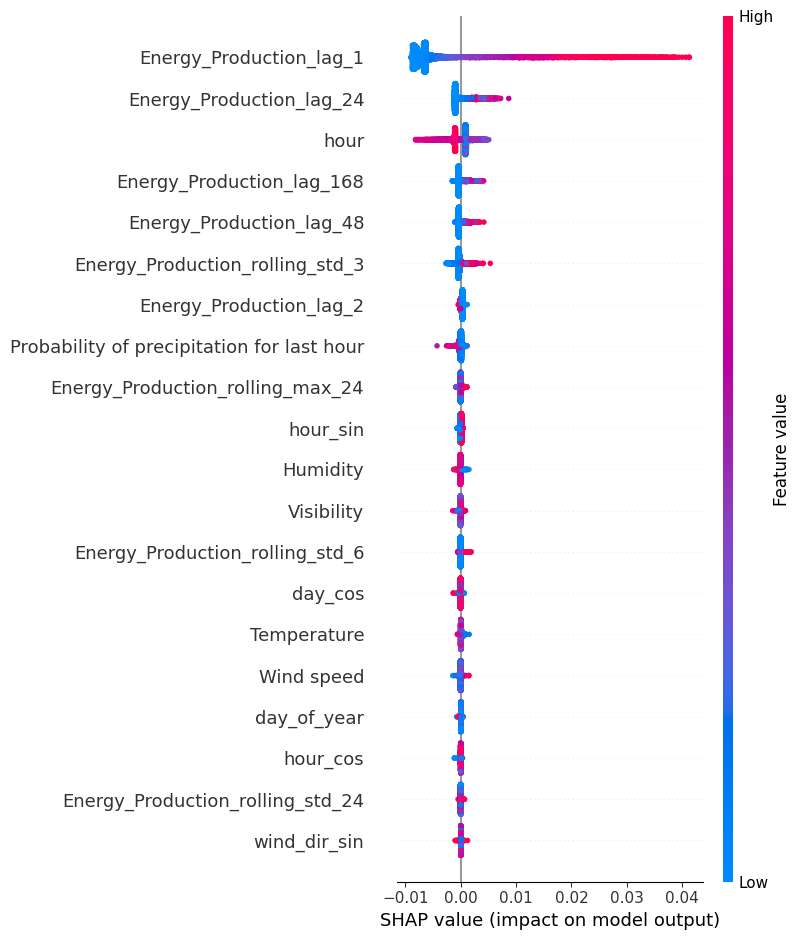

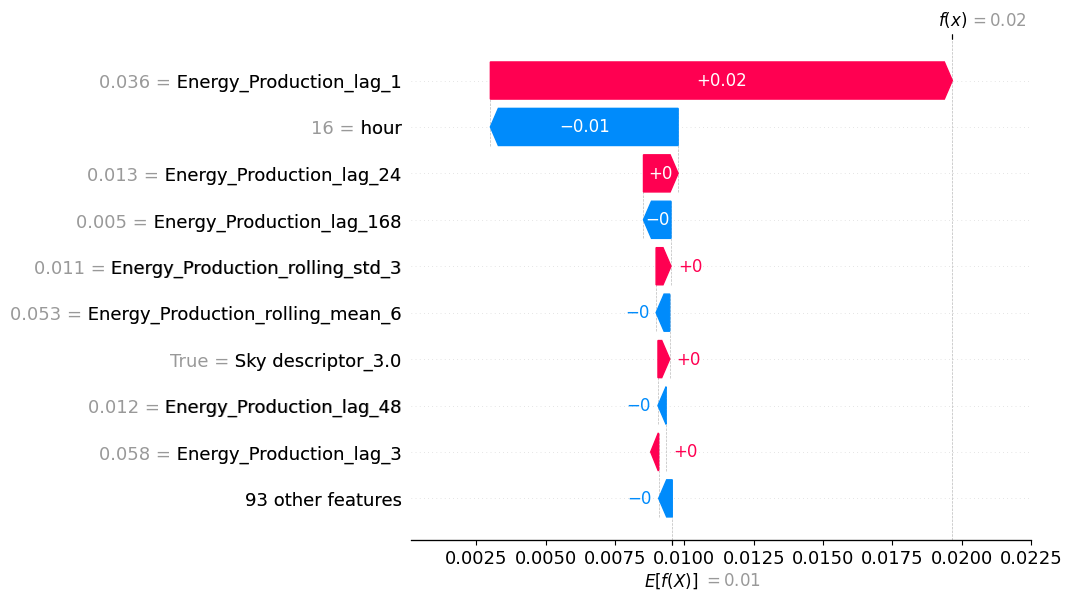

In [ ]:
X_shap = X_pi  # we reuse the same sample for speed

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_shap)

# Global summary
shap.summary_plot(shap_values, X_shap)

# Local explanation (one example)
i = 0
shap.waterfall_plot(shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_shap.iloc[i],
    feature_names=X_shap.columns
))


### Local Model Explanation (SHAP Waterfall Plot)

The SHAP waterfall plot explains a single prediction by showing how individual features contribute to the final estimated energy production, starting from the model’s expected value.

In this example, the most influential contribution comes from the 1-hour lag of energy production, which increases the prediction substantially. This confirms that recent production history strongly drives short-term forecasts. The hour-of-day feature has a negative contribution, reflecting lower expected production at that specific time of day.

Additional lagged and rolling features provide smaller adjustments, while weather and categorical features play a secondary role for this particular observation. The final prediction results from the cumulative effect of all feature contributions.

Overall, this local explanation aligns with the global feature importance results and confirms that the model relies on meaningful and interpretable drivers rather than spurious patterns.


## Conclusion

In this project, we developed an end-to-end machine learning pipeline to forecast hourly solar energy production for 15 power plants using weather data and historical production signals. Particular attention was paid to time-series integrity, panel-data safety, and fair comparison against the provided benchmark.

After detailed feature engineering (cyclical time encodings, plant-safe lag and rolling statistics) and model comparison, tree-based boosting methods outperformed linear and distance-based models. Among all models, **LightGBM trained on the original feature set** delivered the best overall performance, combining strong predictive accuracy with low computational cost.

On the validation set, the selected model achieved:
- **RMSE = 0.0022**, compared to **0.0066 for the benchmark**,
- representing an **error reduction of approximately 67%**,
- with a **R² of 0.97**, indicating that most of the variability in energy production is successfully explained.

This demonstrates that the machine learning model adds substantial value over the benchmark baseline.

Although PCA reduced multicollinearity among weather variables and slightly improved training speed, it did not lead to higher predictive accuracy for the best-performing models. This confirms that boosting models such as LightGBM can efficiently handle correlated inputs without dimensionality reduction.

Explainability analyses using permutation importance and SHAP further validated the model’s behaviour. Predictions are primarily driven by short-term and seasonal production dynamics (recent lags and rolling statistics), complemented by time-of-day effects and selected weather conditions. Local SHAP explanations show coherent, interpretable contributions, increasing confidence in the model’s reliability.

Finally, the comparison between global and local models revealed moderate heterogeneity across plants, but no systematic performance breakdown. This supports the use of a **global modelling strategy** with plant identifiers, which remains scalable while preserving strong predictive power.

Overall, the results confirm that a carefully designed machine learning approach can significantly improve solar energy production forecasting and provide actionable insights for operational planning and energy management.
